# 方式分割脑图像

## 一、加载数据

先导入需要的包

In [1]:
# 导入需要的包
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image,ImageOps
from mxtorch import transforms as tfs
from datetime import datetime
import random

import matplotlib.pyplot as plt
%matplotlib inline

----

定义一个函数进行图片的读入，先设置好数据集的路径，并不执行

根据 `train.txt` 和 `val.txt` 中的文件名进行图片读入，之后根据图片名称生成 batch 的时候再读入图片

In [2]:
M_root = './M'#数据根目录

def read_images(root=M_root, train=True):
    txt_fname = root + '/sets/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'images', i+'.bmp') for i in images]
    label = [os.path.join(root, 'class', i+'.bmp') for i in images]
    return data, label

随机crop图片，数据增强，从一张图片中 crop 出固定大小的区域，然后在 label 上也做同样方式的crop


定义一个随机crop函数，不仅输出 crop 出来的区域，同时还要输出对应的坐标，便于在 label 上做相同的 crop

---
# 随机旋转new

In [3]:
def randomRotation(data, label, degree,mode=Image.BICUBIC):
  
        """
         对图像进行随机任意角度(0~360度)旋转
        :param mode 邻近插值,双线性插值,双三次B样条插值(default)
        :param image PIL的图像image
        :return: 旋转转之后的图像
        """
        random_angle = np.random.randint(1, degree)
        return data.rotate(random_angle, mode) , label.rotate(random_angle, Image.NEAREST)

# 随机剪裁图片

In [4]:
def random_crop(data, label, crop_size):
    height, width = crop_size
    data, rect = tfs.RandomCrop((height, width))(data)
    label = tfs.FixedCrop(*rect)(label)
    return data, label

----
脑图像中有4种类别，将每种类别与其相应的 RGB 值对应上

In [5]:
classes = ['background','CSF','GM','WM']

# RGB color for each class
colormap = [[0,0,0],[85,85,85],[170,170,170], [255,255,255]]

len(classes), len(colormap)

(4, 4)

接着建立一个索引，将一个类别的 RGB 值对应到一个整数上

通过这种一一对应的关系，将 label 图片变成一个矩阵，矩阵和原图片一样大，但是只有一个通道数，也就是 (h, w) 这种大小，里面的每个数值代表着像素的类别

In [6]:
cm2lbl = np.zeros(256**3) # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # 建立索引

def image2label(img):
    data = np.array(img, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # 根据索引得到 label 矩阵

接着定义数据预处理方式，之前读取的数据只有文件名，现在开始做预处理

首先随机 crop 出固定大小的区域，然后使用 ImageNet 的均值和方差做标准化

In [7]:
def img_transforms(img,label, crop_size,degree):#,center_crop_size
    
    #img, label = random_horizontally_flip()(img, label)
    img, label = randomRotation(img, label,degree)
    #img, label = center_crop(img, label, center_crop_size)
    img, label = random_crop(img, label, crop_size)
    
    img_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = img_tfs(img)
    label = image2label(label)
    label = torch.from_numpy(label)
    return img, label

最后，定义一个 MRSegDataset 继承于 `torch.utils.data.Dataset` 构成我们自定的训练集

In [8]:
class MRSegDataset(Dataset):
    '''
    mr dataset
    '''
    def __init__(self, train,crop_size,degree,transforms):# center_crop_size,
        #self.center_crop_size = center_crop_size
        self.crop_size = crop_size
        self.degree = degree
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        print('Read ' + str(len(self.data_list)) + ' images')
        
    def _filter(self, images): # 过滤掉图片大小小于 crop 大小的图片
        return [im for im in images if (Image.open(im).size[1] >= self.crop_size[0] and 
                                        Image.open(im).size[0] >= self.crop_size[1])]
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img, label = self.transforms(img, label,self.crop_size, self.degree)# self.center_crop_size, 
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [9]:
# 实例化数据集
#center_crop_size = 270
crop_size = (200,200)
traindegree = 180
input_shape = (384, 384)
testdegree = 2

mr_train = MRSegDataset(True, crop_size, traindegree,img_transforms)
mr_test = MRSegDataset(False, input_shape,testdegree, img_transforms)

train_data = DataLoader(mr_train, 8, shuffle=True, num_workers=2)
valid_data = DataLoader(mr_test, 8, num_workers=1)

Read 256 images
Read 48 images


## 二、构造模型

U-Net

定义几个U-Net中的下采样模块

In [10]:
def conv3x3(in_channel, out_channel, stride=1):
    return nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)

In [11]:
class residual_block(nn.Module):
    def __init__(self, in_channel, out_channel, same_shape=True):
        super(residual_block, self).__init__()
        self.same_shape = same_shape
        stride=1 if self.same_shape else 2
        
        self.conv1 = conv3x3(in_channel, out_channel, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        
        self.conv2 = conv3x3(out_channel, out_channel)
        self.bn2 = nn.BatchNorm2d(out_channel)
        if not self.same_shape:
            self.conv3 = nn.Conv2d(in_channel, out_channel, 1, stride=stride)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out), True)
        out = self.conv2(out)
        out = F.relu(self.bn2(out), True)
        
        if not self.same_shape:
            x = self.conv3(x)
        return F.relu(x+out, True)

定义U-Net中的上采样块

In [12]:
class UNetEnc(nn.Module):

    def __init__(self, in_channels, features, out_channels):#三个参数，输入通道、块中间层通道数、输出通道
        super().__init__()

        self.up = nn.Sequential(
            nn.Conv2d(in_channels, features, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, 3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features, out_channels, 2, stride=2),#上采样
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.up(x)

搭建网络

In [13]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.dec1 = residual_block(3, 64,False)
        self.dec2 = residual_block(64, 128,False)
        self.dec3 = residual_block(128, 256,False)
        self.dec4 = residual_block(256, 512, False)
        self.center = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.ConvTranspose2d(1024, 512, 2, stride=2),
            nn.ReLU(inplace=True),
        )
        self.enc4 = UNetEnc(1024, 512, 256)
        self.enc3 = UNetEnc(512, 256, 128)
        self.enc2 = UNetEnc(256, 128, 64)
        self.enc1 = nn.Sequential(
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        dec1 = self.dec1(x)
        dec2 = self.dec2(dec1)
        dec3 = self.dec3(dec2)
        dec4 = self.dec4(dec3)
        center = self.center(dec4)
        enc4 = self.enc4(torch.cat([
            center, F.upsample_bilinear(dec4, center.size()[2:])], 1))
        #因为下采样块的输出已经max polling了，所以这里先对下采样块的输出双线性插值一下，再和反卷积后的特征图cat到一块
        enc3 = self.enc3(torch.cat([
            enc4, F.upsample_bilinear(dec3, enc4.size()[2:])], 1))
        enc2 = self.enc2(torch.cat([
            enc3, F.upsample_bilinear(dec2, enc3.size()[2:])], 1))
        enc1 = self.enc1(torch.cat([
            enc2, F.upsample_bilinear(dec1, enc2.size()[2:])], 1))

        return F.upsample_bilinear(self.final(enc1), x.size()[2:])

In [14]:
num_classes = len(classes)

In [15]:
net = UNet(num_classes)
net = net.cuda()

多GPU处理(可选)

In [16]:
net=nn.DataParallel(net,device_ids=[0,1])

加载预训练权重

In [17]:
net.load_state_dict(torch.load('save_u_res_params(0.86,augument).pth'))

In [18]:
from mxtorch.vision.eval_tools import eval_semantic_segmentation

In [19]:
# 定义 loss 和 optimizer
from mxtorch.trainer import ScheduledOptim
criterion = nn.NLLLoss2d()
#basic_optim = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)
basic_optim = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer = ScheduledOptim(basic_optim)

/home/ql/.conda/envs/QL/lib/python3.6/site-packages/torch/nn/modules/loss.py:198: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see http://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [20]:
for e in range(100):
    if e > 0 and e % 50 == 0:
        optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0
    train_mean_dice = 0
    
    prev_time = datetime.now()
    net = net.train()
    for data in train_data:
        im = Variable(data[0].cuda())
        labels = Variable(data[1].cuda())
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)
        
        train_acc += eval_metrics['mean_class_accuracy']
        train_mean_iu += eval_metrics['miou']
        train_mean_dice += eval_metrics['mdice']
        
    net = net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    eval_mean_dice = 0
    
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        labels = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, labels)
        eval_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

    eval_acc += eval_metrics['mean_class_accuracy']
    eval_mean_iu += eval_metrics['miou']
    eval_mean_dice += eval_metrics['mdice']
    
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, Train Mean dice: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f},valid Mean dice: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data), train_mean_dice / len(train_data),
        eval_loss / len(valid_data), eval_acc, eval_mean_iu,eval_mean_dice))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str + ' lr: {}'.format(optimizer.learning_rate))

/home/ql/.conda/envs/QL/lib/python3.6/site-packages/torch/nn/functional.py:1820: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ql/.conda/envs/QL/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyT

Epoch: 0, Train Loss: 0.43120, Train Acc: 0.54823, Train Mean IU: 0.42537, Train Mean dice: 0.50619, Valid Loss: 0.14714, Valid Acc: 0.52186, Valid Mean IU: 0.35971,valid Mean dice: 0.42103 Time: 0:0:10 lr: 0.001
Epoch: 1, Train Loss: 0.24102, Train Acc: 0.66003, Train Mean IU: 0.54575, Train Mean dice: 0.64533, Valid Loss: 0.11706, Valid Acc: 0.66061, Valid Mean IU: 0.52415,valid Mean dice: 0.62642 Time: 0:0:7 lr: 0.001
Epoch: 2, Train Loss: 0.20689, Train Acc: 0.71015, Train Mean IU: 0.59661, Train Mean dice: 0.70861, Valid Loss: 0.08314, Valid Acc: 0.74997, Valid Mean IU: 0.64466,valid Mean dice: 0.74527 Time: 0:0:7 lr: 0.001
Epoch: 3, Train Loss: 0.20436, Train Acc: 0.72123, Train Mean IU: 0.60558, Train Mean dice: 0.71733, Valid Loss: 0.07972, Valid Acc: 0.82252, Valid Mean IU: 0.73870,valid Mean dice: 0.82843 Time: 0:0:7 lr: 0.001
Epoch: 4, Train Loss: 0.18910, Train Acc: 0.73279, Train Mean IU: 0.61939, Train Mean dice: 0.73046, Valid Loss: 0.07752, Valid Acc: 0.79962, Valid Mea

In [26]:
torch.save(net.state_dict(), 'save_u_res_params(0.86,augument).pth')

In [19]:
# net.load_state_dict(torch.load('./fcn.pth'))
net = net.eval()

In [20]:
classes = ['background','CSF','GM','WM']

# RGB color for each class
colormap_new = [[10,10,10],[240,255,240],[16,78,139], [205,133,63]]

len(classes), len(colormap)

(4, 4)

In [21]:
# 定义预测函数
cm = np.array(colormap_new).astype('uint8')

def predict(img, label): # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

/home/ql/.conda/envs/QL/lib/python3.6/site-packages/torch/nn/functional.py:1820: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


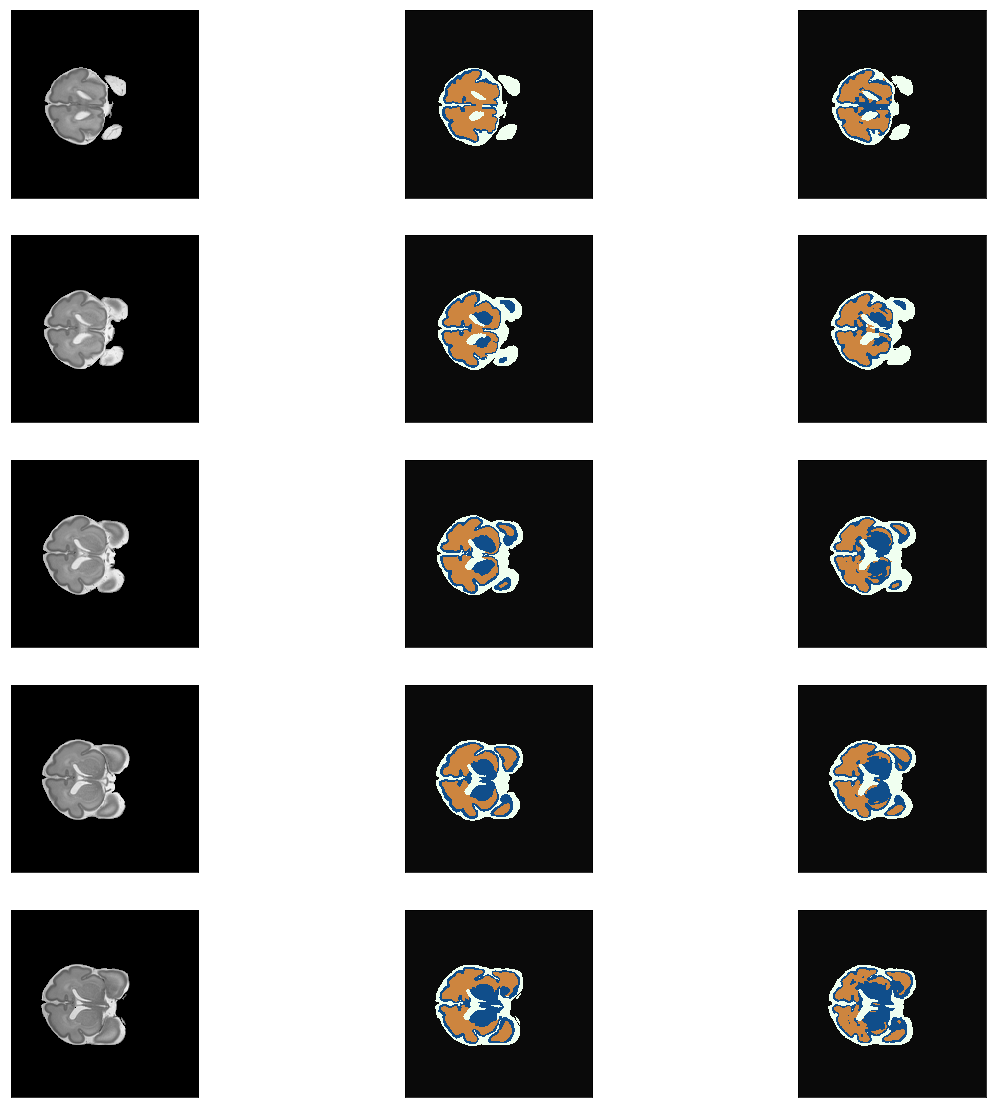

In [34]:
_, figs = plt.subplots(5, 3, figsize=(20, 20))
N = 12

for i in range(5):
    test_data, test_label = mr_test[i+N]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(mr_test.data_list[i+N]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
    new_im = Image.fromarray(pred.astype(np.uint8))
    new_im.save('./pred'+np.str(i)+'.bmp')
    label_im = Image.fromarray(label.astype(np.uint8))
    label_im.save('./label'+np.str(i)+'.bmp')
    img = Image.open(mr_test.data_list[i+N])
    img.save('./img'+np.str(i)+'.bmp')